## Тематическое моделирование

*Галушко Илья, НИУ ВШЭ*

**Загрузка файла с текстами**

In [ ]:

from google.colab import files
uploaded = files.upload()

Saving Belanovskiy.txt to Belanovskiy.txt


**Загрузка языковой модели Spacy**

In [ ]:
import warnings
from IPython.display import clear_output
! pip install -U spacy

clear_output()

In [ ]:
! python -m spacy download ru_core_news_sm
clear_output()

In [ ]:
from gensim.models import TfidfModel
import nltk as nltk
nltk.download('stopwords')
import re
from string import punctuation
from nltk import ngrams
import numpy as np
import json
import glob
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
import spacy
from nltk.corpus import stopwords
!pip install pyLDAvis # установка pyLDAvis
import pyLDAvis.gensim_models

f = open('Belanovskiy.txt', encoding='utf-8', mode='r')
text_a = f.read()
f.close()
data = text_a.split('______________')

stopwords = stopwords.words("russian")

def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("ru_core_news_sm")
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return texts_out


lemmatized_texts = lemmatization(data)

clear_output()

**Посмотрим на оригинальный текст**

In [ ]:
print(data[3][0:3000])


Интервью с рабочим инструментального цеха (1986 год)


1
  Подобная установка является, по-видимому, широко распространенной и характерной. Директор
одного из предприятий горнодобывающей промышленности рассказывал интервьюеру, как к нему
пришел рабочий и выразил недовольство размером своей зарплаты - около 400 рублей в месяц.
Директор сказал на это, что он сам получает столько же. "Но ведь ты же не работаешь" - ответил
рабочий (примечание интервьюера).
    Б. Пинскер, С. Белановский, Т. Федоровская

     Вопрос: Расскажите, как Вы стали рабочим и где работали?
     Получилось так, что я оставил место, на котором работал прежде, и поскольку
я ушел с "шумом", то в течение полугода не мог найти никакого другого места,
никакой работы по специальности и, в конце концов, оказался вынужденным пойти
на завод.
     Вопрос: А какое у Вас образование?
     Высшее. Я экономист. На заводе я три года работал слесарем-
инструментальщиком, дослужился до 4-го разряда. Но тут произошли некоторые
измен

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Посмотрим на лемматизированный текст**

In [ ]:
warnings.filterwarnings('ignore')

print(lemmatized_texts[3])


интервью рабочий инструментальный цех 1986 год подобный установка являться по - видимому широко распространенной характерный директор предприятие горнодобывающей промышленность рассказывать интервьюер прийти рабочий выразить недовольство размер зарплата - рубль месяц директор сказать сам получать столько работаешь ответить рабочий примечание интервьюер фёдоровский вопрос рассказать стать рабочий где работать получиться так оставить место работать прежде уйти шум течение полугода мочь найти другого место работа специальность в конец конец оказаться вынужденный пойти завод вопрос образование высокий экономист завод год работать слесарем- инструментальщик дослужиться 4-й разряд тут произойти изменение жена написать книжка принять редакция - возникнуть другие перспектива жизнь другой сторона окончание книга нужный много время поэтому уйти завод месяц сидеть дома вопрос прийти завод время работать там сейчас вспомнить ноябрь 1982 год начать работать там май 1986 год - уволиться вопрос предс

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Добавление в тексты биграмм и создание основной LDA модели**

In [ ]:
warnings.filterwarnings('ignore')


def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        new_1 = [token for token in new if token not in stopwords]
        final.append(new_1)
    return (final)


data_words = gen_words(lemmatized_texts)

bigrams_phases = gensim.models.Phrases(data_words, min_count=5, threshold=50)
trigram_phrases = gensim.models.Phrases(bigrams_phases[data_words], threshold=50)

bigram = gensim.models.phrases.Phraser(bigrams_phases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)


def make_bigrams(texts):
    return (bigram[doc] for doc in texts)


def make_trigrams(texts):
     return (trigram[bigram[doc]] for doc in texts)


data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

new_data_text = list(data_bigrams_trigrams)


id2word = corpora.Dictionary(new_data_text)

texts = new_data_text

corpus = [id2word.doc2bow(text) for text in texts]

tfidf = TfidfModel(corpus, id2word = id2word)

low_value = 0.02
words = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = []
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow


lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=40,
                                            passes=15,
                                            alpha="auto")

f.close()

**Посмотрим на текст с добавленными биграммами**

In [ ]:
print(new_data_text[3])

['интервью', 'рабочии', 'цех', 'год', 'подобныи', 'установка', 'являться', 'видимому', 'широко', 'характерныи', 'директор', 'предприятие', 'горнодобывающеи', 'промышленность', 'рассказывать', 'интервьюер', 'приити', 'рабочии', 'выразить', 'недовольство', 'размер', 'зарплата', 'рубль', 'месяц', 'директор', 'сказать', 'получать', 'столько', 'работать', 'ответить', 'рабочии', 'примечание_интервьюер', 'федоровскии', 'вопрос', 'рассказать', 'стать', 'рабочии', 'работать', 'получиться', 'оставить', 'место', 'работать', 'прежде', 'уити', 'шум', 'течение', 'полугода', 'мочь', 'наити', 'другого', 'место', 'работа', 'специальность', 'конец_конец', 'оказаться', 'вынужденныи', 'поити', 'завод', 'вопрос', 'образование', 'высокии', 'экономист', 'завод', 'год', 'работать', 'слесарем', 'дослужиться', 'разряд', 'произоити', 'изменение', 'жена', 'написать', 'книжка', 'принять', 'редакция', 'возникнуть', 'какие', 'другие', 'перспектива', 'жизнь', 'другои_сторона', 'окончание', 'книга', 'нужныи', 'время',

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Посмотрим на числовое представление текста**

In [ ]:
print(corpus[3])

[(18, 2), (38, 2), (71, 5), (174, 9), (197, 8), (383, 3), (588, 4), (623, 7), (728, 9), (729, 10), (964, 4), (966, 2), (1122, 3), (1130, 5), (1241, 4), (1261, 11), (1340, 2), (1520, 4), (1563, 2), (1683, 4), (1762, 5), (1954, 2), (2022, 10), (2232, 12), (2276, 7), (2342, 5), (2521, 3), (2522, 3), (2584, 5), (2702, 17), (2970, 2), (3030, 2), (3036, 6), (3062, 3), (3063, 2), (3167, 4), (3315, 2), (3435, 2), (3491, 24), (3495, 10), (3503, 56), (3605, 2), (3931, 4), (4053, 2), (4279, 2), (4421, 2), (4605, 4), (4681, 2), (4906, 9), (5008, 3), (5213, 3), (5269, 4), (5648, 12), (5977, 4), (6017, 2), (6058, 3), (6104, 2), (6640, 3), (6825, 2), (6833, 2), (6836, 2), (6852, 2), (6861, 2), (6869, 2), (6870, 2), (6880, 3), (6889, 2), (6894, 2), (6971, 3), (6977, 3), (6989, 3), (6992, 2), (6994, 2), (7029, 2), (7030, 3), (7037, 2), (7050, 2), (7057, 3), (7062, 2), (7068, 2), (7070, 3), (7082, 2), (7112, 5), (7116, 2), (7132, 2), (7133, 3), (7148, 5), (7154, 3)]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Загружаем инструменты визуализации**

Попробуйте уменьшить значение λ. Это позволит оставить для каждой темы только те токены, которые характерны исключительно для этого топика.




In [ ]:
import pyLDAvis
import pyLDAvis.gensim

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=15)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.064418  0.358654       1        1  37.858755
5      0.258188 -0.165209       2        1  13.833467
0      0.159043  0.236679       3        1   9.120762
2      0.031639 -0.177359       4        1   7.152379
9     -0.302302  0.085012       5        1   6.768357
4      0.253268  0.027068       6        1   6.581295
3      0.138569 -0.080034       7        1   6.522743
1     -0.252254 -0.121623       8        1   5.282376
7     -0.092402  0.072515       9        1   3.577160
8     -0.129331 -0.235704      10        1   3.302706, topic_info=              Term         Freq        Total Category  logprob  loglift
2517       рабочии  1179.000000  1179.000000  Default  15.0000  15.0000
2294   предприятие  1175.000000  1175.000000  Default  14.0000  14.0000
1297  министерство   620.000000   620.000000  Default  13.0000  13.0000
2511        работа   634.000000   634.000000  Default  12.0000  12.0000
3464           цех   922.000000   922.000000  Default  11.0000  11.0000
...            ...          ...          ...      ...      ...      ...
44            база    26.837563    68.403999  Topic10  -4.3180   2.4748
565         деньга    24.907297    68.871121  Topic10  -4.3927   2.3934
590       директор    29.898685   387.617465  Topic10  -4.2100   0.8482
1680   объединение    13.152366    43.276067  Topic10  -5.0312   2.2194
503        грузчик    11.365099    31.960264  Topic10  -5.1773   2.3765

[362 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
3601       1  0.940806  администрация
3601       5  0.015615  администрация
3601       8  0.007808  администрация
3601       9  0.031230  администрация
8662      10  0.893762       апельсин
...      ...       ...            ...
3541      10  0.018775      экономист
10281      2  0.178651     экспертиза
10281      7  0.774153     экспертиза
6301       4  0.755213        элемент
6301      10  0.151043        элемент

[659 rows x 3 columns], R=15, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 1, 3, 10, 5, 4, 2, 8, 9])

In [ ]:
p = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=id2word)
pyLDAvis.save_html(p, 'Belanovskiy.html')

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Визуализация облака слов**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


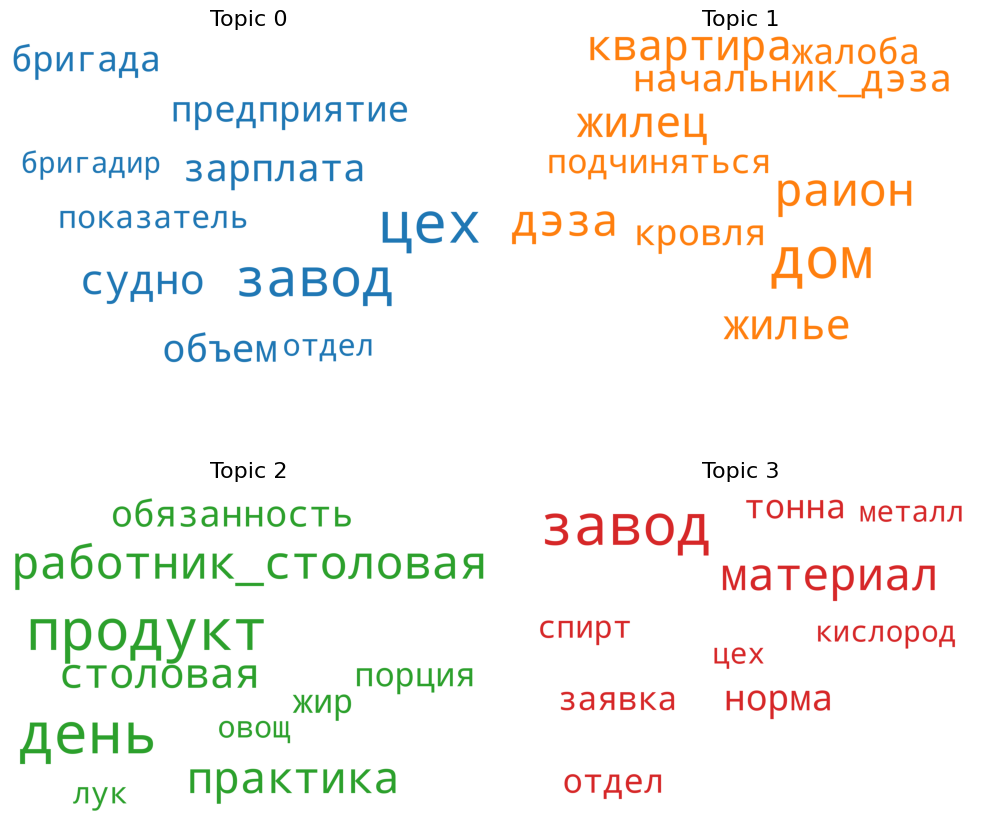

In [ ]:
# С ЛЯМБДА 1 облако слов
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

**График подсчета встречаемости слов**


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-39-108febaf90df>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


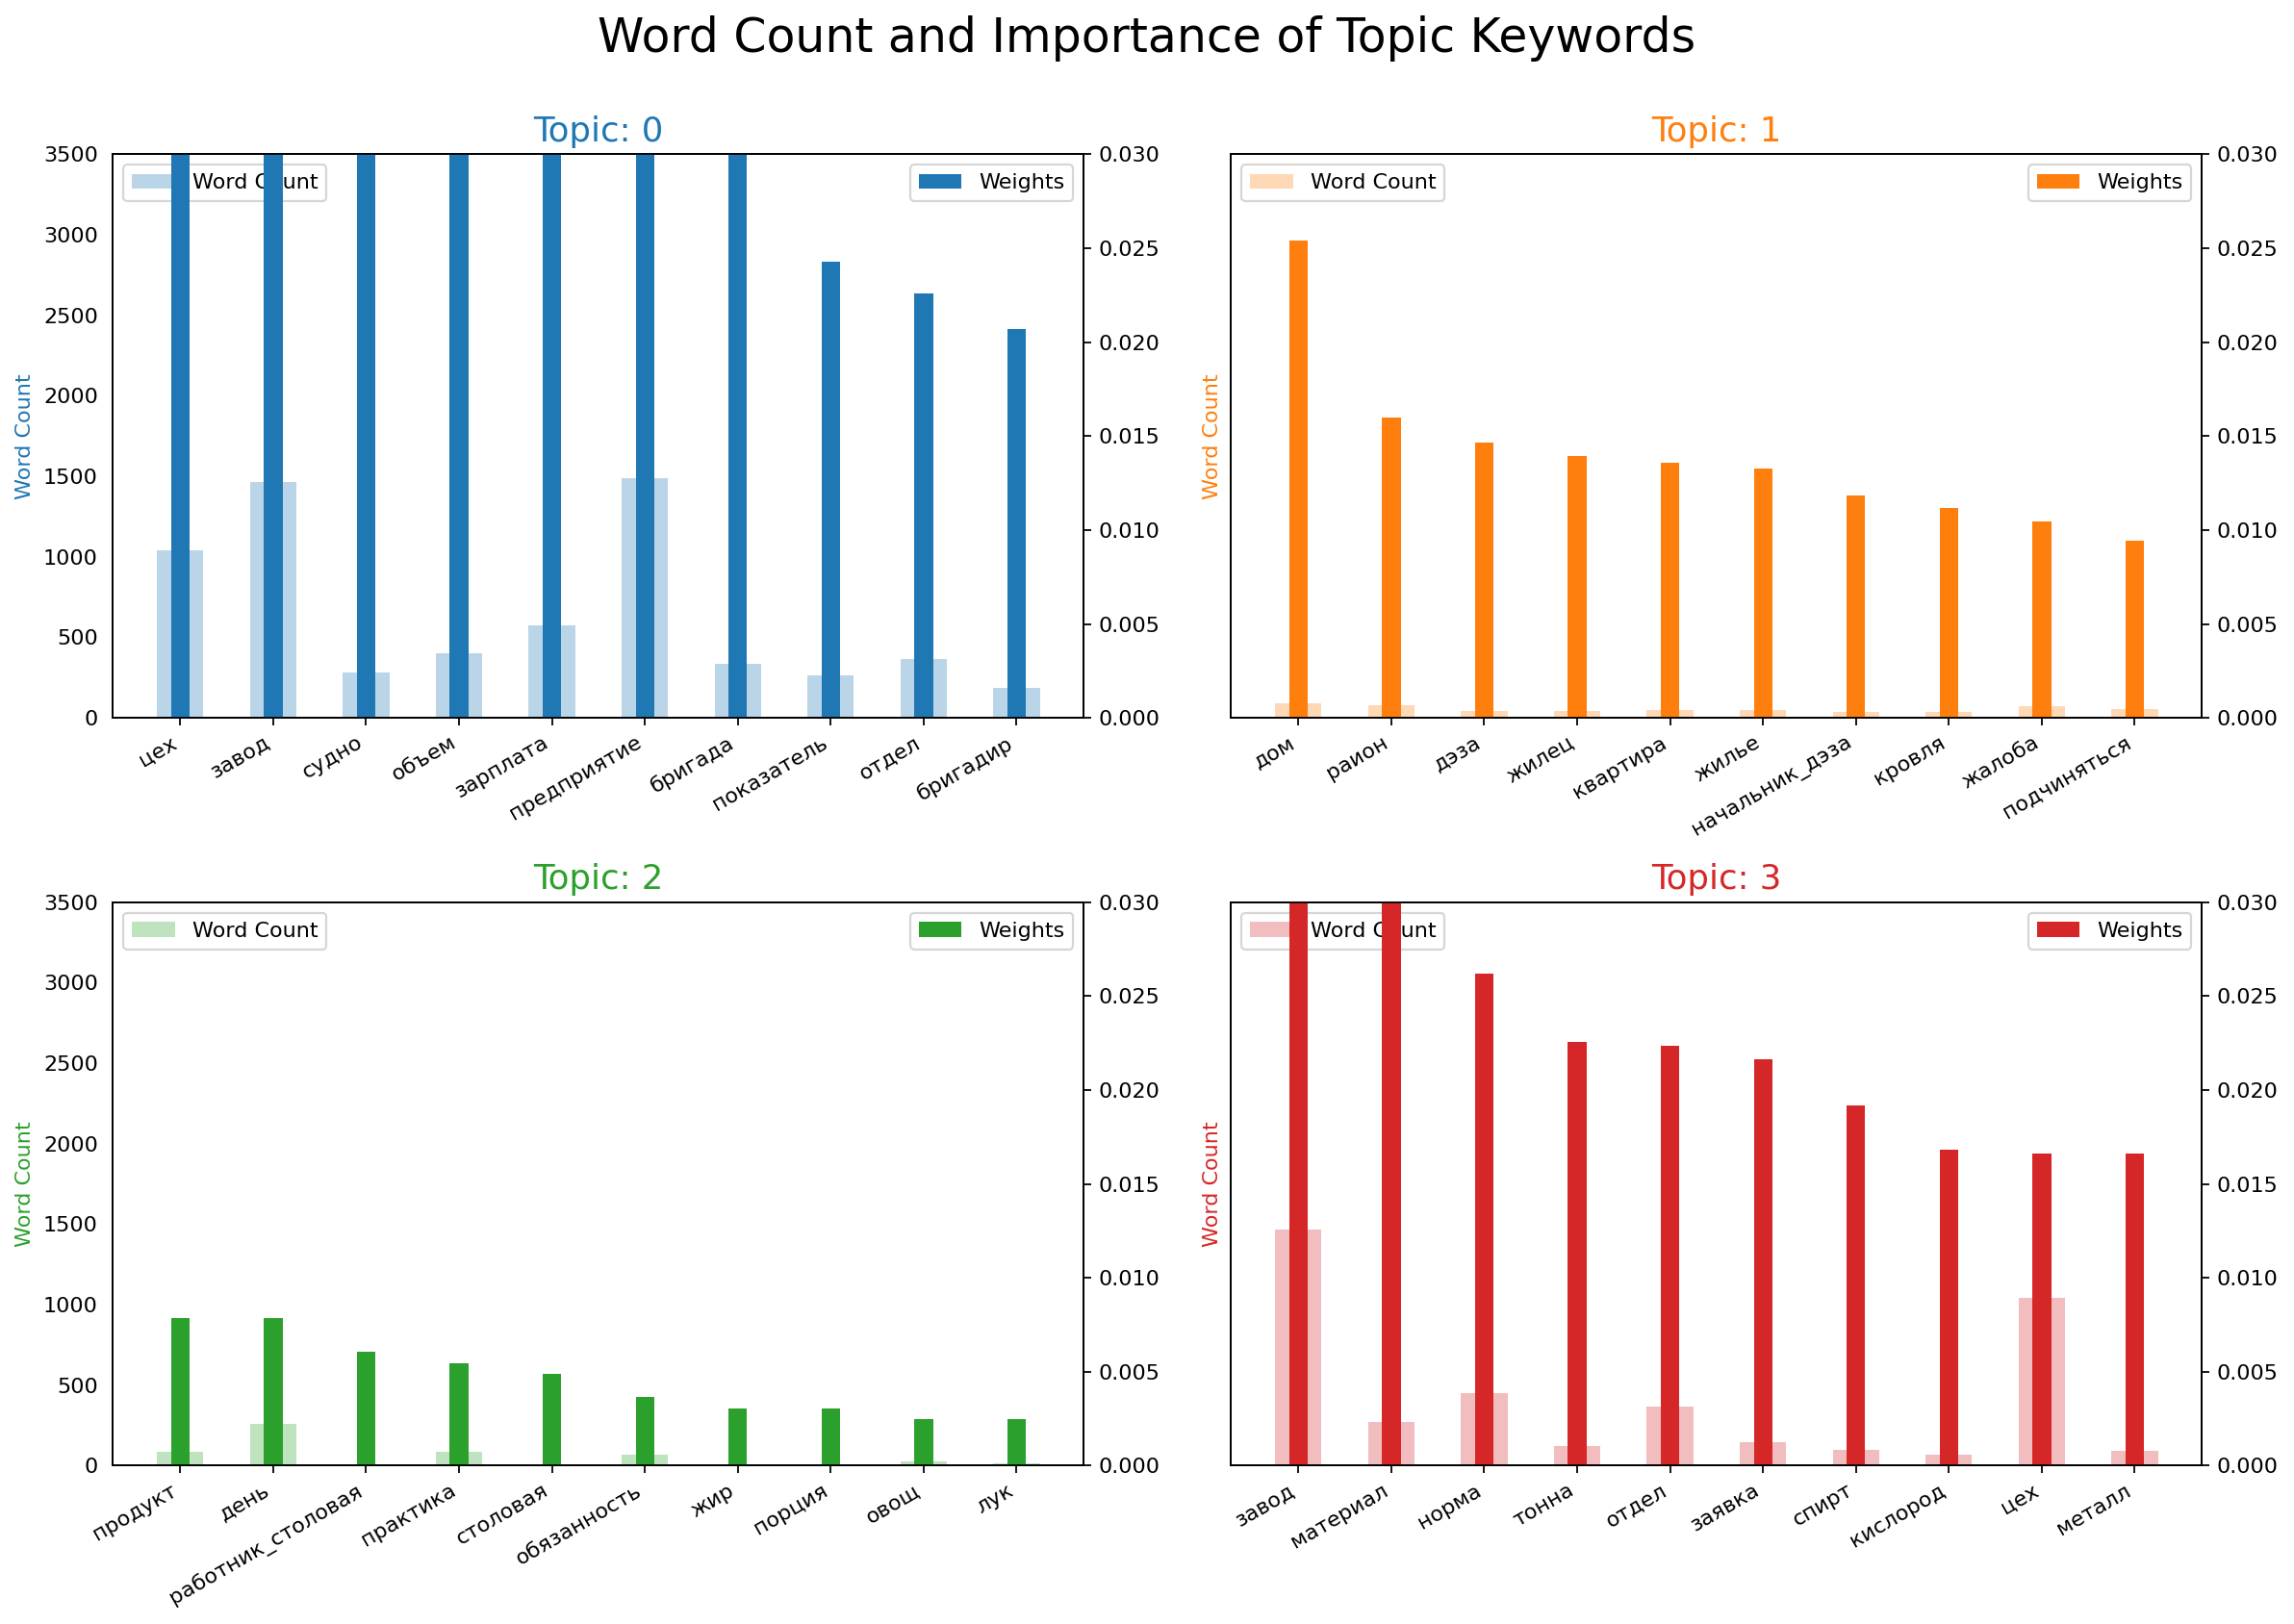

In [ ]:
# word count graph
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in new_data_text for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(15,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

**Построить таблицу с ключевыми словами**

In [ ]:
# построить таблицу с ключевыми словами
import pandas as pd

def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

# Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=new_data_text)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['x', 'Преобладает в топике:', 'Topic_Perc_Contrib', 'Ключевые слова', 'Тексты интервью']
df_dominant_topic.head(10)

,x,Преобладает в топике:,Topic_Perc_Contrib,Ключевые слова,Тексты интервью
0,0,5.0,0.9999,"завод, цех, директор, объем, зарплата, отдел, ...","[интервью, работник, отдел_снабжение, завод, а..."
1,1,8.0,1.0000,"рабочии, цех, администрация, участок, оборудов...","[интервью, рабочим, завод, производство, элект..."
2,2,6.0,0.9996,"цех, станок, участок, отношение, женщина, нала...","[интервью, рабочии, шлифовщица, разряд, год, б..."
3,3,2.0,0.9494,"предприятие, министерство, завод, продукция, с...","[интервью, рабочии, цех, год, подобныи, устано..."
4,4,7.0,0.9994,"водитель, завод, машина, тонно_километр, строи...","[интервью, рабочии, автобаза, год, вопрос, раб..."
5,5,1.0,0.9996,"дом, раион, жилец, объект, квартира, кровля, д...","[интервью, рабочии, строитель, апрель, год, во..."
6,6,7.0,0.9991,"водитель, завод, машина, тонно_километр, строи...","[интервью, директор, завод, изделие, вопрос, п..."
7,7,8.0,0.8594,"рабочии, цех, администрация, участок, оборудов...","[интервью, начальник, отдел, кадр, химическии,..."
8,8,6.0,0.9987,"цех, станок, участок, отношение, женщина, нала...","[интервью, начальник, цех, завод, август, год,..."
9,9,5.0,0.7106,"завод, цех, директор, объем, зарплата, отдел, ...","[главныи_инженер, вопрос, выполнять, шахта, пл..."
